# Importations

In [22]:
# from sklearnex import patch_sklearn
# patch_sklearn()
import sys
sys.path.append("../../code_preparation/")

from src.utils import read_split_csv
from src.mlp.mlp import *
from src.mlp.mlp_plot import *
from src.mlp.scaling_uncertainty import *
import pandas as pd
import torch
import random
print("Torch Version", torch.__version__)

Torch Version 1.11.0


In [23]:
torch.cuda.is_available()

True

if not, in shell : 

sudo rmmod nvidia_uvm && sudo modprobe nvidia_uvm

# Load data
(quadricoptere dataset)

## With all flights mixed together

In [5]:
datasets = read_split_csv("/App/Data/split_quad/")
datasets["val"]

val.csv
train.csv


test.csv
lourd.csv


,time_start,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,route,power,power_smoothed
index,,,,,,,,,,,,,,,,,,,,,
109923,2019-07-03 03:10:00,150,35.50,2.8,238.0,22.759777,23.505444,-79.782777,40.458953,365.169441,...,-0.076906,0.335496,-0.143232,-9.869870,12,0,100,R1,534.978656,537.998819
91658,2019-06-29 12:40:00,136,78.60,9.4,4.0,21.084534,26.065914,-79.782571,40.458586,290.375622,...,-0.082310,-1.529684,0.423300,-9.976319,8,250,25,R1,549.587645,526.000169
200354,2019-07-24 16:28:00,229,62.60,10.5,204.0,22.172565,18.448116,-79.782210,40.458218,315.845911,...,0.015051,-1.633767,0.061935,-9.457129,10,0,50,R1,409.042066,432.243997
122937,2019-07-03 16:35:00,162,3.10,0.9,265.0,21.716820,24.189297,-79.782738,40.458992,276.467557,...,-0.054514,0.133585,-0.133318,-10.589297,8,500,75,R1,525.314597,536.179872
164684,2019-07-15 08:05:00,195,112.60,2.2,128.0,23.306925,17.772215,-79.782766,40.459063,367.520864,...,0.018428,0.267958,-0.178819,-8.603159,8,250,100,R1,414.215676,420.793236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119371,2019-07-03 16:10:00,158,4.20,1.0,70.0,22.375399,21.795813,-79.782763,40.458980,270.231115,...,0.012899,0.072653,0.035458,-9.965531,12,250,75,R1,487.689996,544.146733
228319,2019-08-05 18:00:00,252,53.61,2.8,212.0,21.711811,26.304468,-79.781380,40.459499,345.136230,...,-0.000584,-0.393476,0.177744,-9.913366,12,500,75,R1,571.117643,586.617433
255344,2019-10-24 09:45:00,277,72.01,9.0,14.0,21.670494,21.390272,-79.782571,40.458526,293.235121,...,-0.107946,-0.764824,0.548552,-9.283231,10,500,25,R1,463.537766,460.171522


In [6]:
# remove columns 
cols_ignored = ["time_start","battery_voltage","battery_current", "altitude","speed","route", "position_x", "position_y", "flight"]
cols_redundent = ["linear_acceleration_x", "velocity_y", "power"]
target = "power_smoothed"

datasets_cleaned = dict()
for k in datasets.keys():
    datasets_cleaned[k] = datasets[k].drop(columns = cols_ignored + cols_redundent) # + target)

datasets_cleaned["val"]

,time,wind_speed,wind_angle,position_z,orientation_x,orientation_y,orientation_z,orientation_w,velocity_x,velocity_z,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z,payload,power_smoothed
index,,,,,,,,,,,,,,,,,
109923,35.50,2.8,238.0,365.169441,0.019652,-0.009543,-0.892996,0.449534,-0.079833,3.000340,0.006295,0.028133,-0.076906,-0.143232,-9.869870,0,537.998819
91658,78.60,9.4,4.0,290.375622,-0.065850,-0.020889,0.102929,0.992287,-0.505729,0.908372,0.071907,0.034870,-0.082310,0.423300,-9.976319,250,526.000169
200354,62.60,10.5,204.0,315.845911,-0.020135,-0.081124,0.972382,0.217915,0.079185,1.620667,-0.015960,0.032285,0.015051,0.061935,-9.457129,0,432.243997
122937,3.10,0.9,265.0,276.467557,-0.029125,-0.007355,-0.769531,0.637903,-0.045260,0.282797,0.178007,0.083491,-0.054514,-0.133318,-10.589297,500,536.179872
164684,112.60,2.2,128.0,367.520864,0.002847,0.011134,0.129321,0.991536,0.140437,-1.149955,-0.005068,0.014159,0.018428,-0.178819,-8.603159,250,420.793236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119371,4.20,1.0,70.0,270.231115,-0.001946,-0.004951,-0.731368,0.681962,0.014317,0.171766,-0.027388,0.043483,0.012899,0.035458,-9.965531,250,544.146733
228319,53.61,2.8,212.0,345.136230,-0.028327,-0.122869,0.967072,0.221073,0.018804,1.762058,-0.044206,0.016506,-0.000584,0.177744,-9.913366,500,586.617433
255344,72.01,9.0,14.0,293.235121,-0.013434,-0.028738,0.109309,0.993502,-0.773985,-0.051941,0.131445,-0.257779,-0.107946,0.548552,-9.283231,500,460.171522


## New way : with flights not separated

In [24]:
# avec données ou on garde les vols entiers 
datasets = read_split_csv("/App/Data/split_flight/")

# create validation set 
# select n flights from each payload 
L = []
nf = 6
for n, g in datasets["train"].groupby("payload"):
    print(n)
    print(random.sample(set(g.flight), nf))
    L.extend(random.sample(set(g.flight), nf))

datasets["val"] = datasets["train"].loc[datasets["train"].flight.isin(L)]
datasets["train"] = datasets["train"].drop(index=datasets["val"].index)

print(datasets["train"].payload.value_counts(normalize=True))
print(datasets["test"].payload.value_counts(normalize=True))
totallen = datasets["train"].size + datasets["test"].size
print(datasets["train"].size/totallen, datasets["test"].size/totallen)

train.csv
test.csv
0
[260, 5, 79, 176, 150, 146]
250
[118, 196, 256, 17, 270, 191]
500
[156, 238, 152, 269, 94, 275]
0      0.343194
500    0.333454
250    0.323352
Name: payload, dtype: float64
0      0.359352
500    0.331879
250    0.308769
Name: payload, dtype: float64
0.8994377766258623 0.10056222337413773


In [25]:
# add dataset lourd 
datasets["lourd"] = pd.read_csv("/App/Data/split_quad/lourd.csv", index_col=0).drop(columns=["time_start","battery_voltage","battery_current", "altitude","speed",
                                                                                             "route", "position_x", "position_y", "linear_acceleration_x", 
                                                                                             "velocity_y", "power_smoothed"])
datasets["lourd"]

,flight,time,wind_speed,wind_angle,position_z,orientation_x,orientation_y,orientation_z,orientation_w,velocity_x,velocity_z,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z,payload,power
index,,,,,,,,,,,,,,,,,,
22085,76,0.00,1.3,221,271.659393,0.031656,-0.003266,-0.781163,0.623515,0.005638,0.010004,0.001404,-0.001690,0.007516,-0.439657,-9.789563,750,7.700636
22086,76,0.20,1.3,230,271.660441,0.031672,-0.003279,-0.781197,0.623472,0.006756,0.011219,0.003334,0.002115,-0.003717,-0.438917,-9.807742,750,77.439395
22087,76,0.30,1.3,234,271.659338,0.031759,-0.002978,-0.781208,0.623456,0.001088,0.010285,-0.002417,0.008522,-0.025537,-0.484429,-9.774743,750,12.002027
22088,76,0.50,1.5,241,271.660378,0.031749,-0.003085,-0.781182,0.623488,0.003102,0.010345,-0.006565,0.031952,0.002586,-0.427297,-9.782342,750,234.236860
22089,76,0.60,1.5,246,271.658821,0.031864,-0.002958,-0.781288,0.623350,0.000531,0.007867,-0.003637,-0.003621,-0.008331,-0.476638,-9.808387,750,52.691091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23166,76,162.31,2.1,34,271.171746,-0.003198,0.005389,-0.713077,0.701058,-0.046693,-0.069286,0.038525,0.007510,0.021976,-0.166651,-9.812804,750,78.675649
23167,76,162.50,2.2,33,271.164709,-0.003390,0.005251,-0.713051,0.701084,-0.048855,-0.069399,0.030986,-0.031396,0.004096,-0.136412,-9.800713,750,78.568938
23168,76,162.70,2.2,31,271.181600,-0.003667,0.005072,-0.713148,0.700985,-0.042997,-0.055383,0.007617,0.000028,0.004788,-0.063318,-9.808303,750,76.007877


In [26]:
# remove columns 
cols_ignored = ["flight"]
target = "power"

datasets_cleaned = dict()
for k in datasets.keys():
    datasets_cleaned[k] = datasets[k].drop(columns = cols_ignored) 

datasets_cleaned["train"]

,time,wind_speed,wind_angle,position_z,orientation_x,orientation_y,orientation_z,orientation_w,velocity_x,velocity_z,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z,payload,power
index,,,,,,,,,,,,,,,,,
1531,0.00,1.1,178.0,268.830833,-0.000779,0.005692,0.298475,0.954400,-0.009233,0.007667,-0.001621,-0.001778,0.005457,-0.113653,-9.802392,0,10.121494
1532,0.10,1.2,173.0,268.825543,-0.000763,0.005683,0.298431,0.954414,-0.014337,0.012726,-0.002207,0.000437,0.002690,-0.122272,-9.806426,0,656.341326
1533,0.20,1.2,169.0,268.826959,-0.000989,0.005932,0.298317,0.954448,-0.009611,0.013629,0.005904,0.004494,0.025825,-0.120708,-9.803435,0,40.699311
1534,0.40,1.2,160.0,268.823417,-0.001039,0.005962,0.298334,0.954442,-0.009544,0.013195,-0.008197,0.002018,0.003247,-0.089019,-9.812296,0,6.626053
1535,0.60,1.2,153.0,268.824807,-0.000956,0.005893,0.298380,0.954428,-0.010878,0.013461,-0.020062,0.011857,0.004577,-0.121922,-9.797800,0,32.103697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257756,116.11,2.6,180.0,270.146941,0.020484,0.017983,0.011347,0.999564,0.038757,-0.047724,0.003752,-0.003594,0.004261,-0.372928,-9.812629,0,73.386768
257757,116.30,2.6,180.0,270.168574,0.020504,0.017502,0.011056,0.999575,0.030060,-0.037571,-0.042004,0.011623,0.044291,-0.361034,-9.817332,0,82.214738
257758,116.40,2.8,181.0,270.164794,0.020545,0.017249,0.011084,0.999579,0.037211,-0.038548,-0.009871,-0.018115,-0.005242,-0.279831,-9.797699,0,85.595864


## Data scaling

Data scaling description:
* For the time feature `time` we perform a `zeromax` scaling using the maximum time over training set. 
* The flight number is not scaled
* The rest input features and the target are `standardized` (Z-scaling).

In [27]:
input_features = list(datasets_cleaned["train"].columns)
input_features.remove(target)
print(input_features)

['time', 'wind_speed', 'wind_angle', 'position_z', 'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w', 'velocity_x', 'velocity_z', 'angular_x', 'angular_y', 'angular_z', 'linear_acceleration_y', 'linear_acceleration_z', 'payload']


In [28]:
# folder to store models and stats
model_dir = "/App/code_preparation/baselines"

In [29]:
train_data = datasets_cleaned["train"]

# store stats computed on training data so we can use them for inference
means, stds = store_stats(train_data, model_dir)
# time max for max scaling
time_max = train_data.time.max()

In [30]:
data_all_norm = {}
for k in datasets_cleaned.keys():
    data_all_norm[k] = data_normalization(data=datasets_cleaned[k], means=means, stds=stds, time_max=time_max)

In [31]:
train_norm = data_normalization(data=train_data, means=means, stds=stds, time_max=time_max)

dev_in_data = datasets_cleaned["test"]
dev_in_norm = data_normalization(data=dev_in_data, means=means, stds=stds, time_max=time_max)

train_norm

,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z,orientation_w,orientation_x,orientation_y,orientation_z,payload,position_z,power,velocity_x,velocity_z,wind_angle,wind_speed,time
index,,,,,,,,,,,,,,,,,
1531,-0.000391,-0.009499,-0.109250,-0.316253,-0.012325,1.091905,0.269856,0.425186,0.433838,-1.203918,-1.423677,-4.561621,0.303772,-0.230004,1.243139,-1.264847,0.000000
1532,-0.004822,0.001492,-0.118835,-0.334534,-0.020101,1.091946,0.270165,0.425021,0.433778,-1.203918,-1.423842,1.309425,0.292302,-0.226980,1.196242,-1.235388,0.000360
1533,0.056474,0.021619,-0.038681,-0.331217,-0.014336,1.092047,0.265854,0.430019,0.433621,-1.203918,-1.423798,-4.283815,0.302922,-0.226441,1.158725,-1.235388,0.000721
1534,-0.050085,0.009333,-0.116904,-0.264009,-0.031416,1.092030,0.264910,0.430625,0.433645,-1.203918,-1.423909,-4.593378,0.303072,-0.226700,1.074310,-1.235388,0.001441
1535,-0.139739,0.058155,-0.112298,-0.333791,-0.003473,1.091989,0.266478,0.429235,0.433708,-1.203918,-1.423865,-4.361908,0.300074,-0.226541,1.008655,-1.235388,0.002162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257756,0.040209,-0.018509,-0.113392,-0.866129,-0.032059,1.225691,0.674163,0.671949,0.041945,-1.203918,-1.382467,-3.986843,0.411619,-0.263106,1.261898,-0.822957,0.418414
257757,-0.305545,0.056992,0.025295,-0.840905,-0.041126,1.225725,0.674553,0.662312,0.041547,-1.203918,-1.381790,-3.906639,0.392074,-0.257039,1.261898,-0.822957,0.419099
257758,-0.062731,-0.090561,-0.146314,-0.668688,-0.003278,1.225735,0.675325,0.657223,0.041586,-1.203918,-1.381908,-3.875920,0.408145,-0.257623,1.271277,-0.764038,0.419459


In [32]:
train_norm.shape

(157899, 17)

In [33]:
train_ds = VPowerDataset(data=train_norm,
                         input_features=input_features,
                         target=target)
val_ds = VPowerDataset(data=dev_in_norm,
                       input_features=input_features,
                       target=target)
                       
train_ds.norm_df.describe()

,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z,orientation_w,orientation_x,orientation_y,orientation_z,payload,position_z,power,velocity_x,velocity_z,wind_angle,wind_speed,time
count,1.578990e+05,1.578990e+05,1.578990e+05,1.578990e+05,1.578990e+05,1.578990e+05,1.578990e+05,1.578990e+05,1.578990e+05,1.578990e+05,1.578990e+05,1.578990e+05,1.578990e+05,1.578990e+05,157899.000000,1.578990e+05,157899.000000
mean,1.687493e-17,-1.411870e-18,1.349995e-17,-8.045969e-17,-5.780507e-14,-3.887985e-17,1.738793e-16,2.293191e-16,3.527986e-17,7.343971e-17,3.434119e-12,4.327759e-14,1.201675e-15,-1.132196e-15,1.197186,-1.051196e-16,0.280851
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.176549
min,-1.721415e+01,-1.823461e+01,-6.563686e+00,-8.225154e+00,-2.485248e+01,-1.735251e+00,-5.401619e+00,-5.294018e+00,-1.338414e+00,-1.203918e+00,-1.718054e+00,-4.665468e+00,-1.270603e+01,-2.634493e+00,-0.426388,-1.559440e+00,0.000000
25%,-4.837892e-01,-2.972780e-01,-3.534693e-01,-5.098399e-01,-3.275159e-01,-1.020540e+00,-3.838843e-01,-4.035800e-01,-8.513433e-01,-1.203918e+00,-7.918913e-01,-4.596223e-01,-3.909490e-01,-7.769319e-01,0.248927,-8.229569e-01,0.134054
50%,5.753023e-03,3.236180e-03,-1.141157e-01,-3.220687e-02,2.236810e-02,3.351332e-01,1.508919e-01,1.119923e-01,1.266560e-01,1.184199e-02,-3.073989e-02,1.619600e-02,1.710243e-01,-6.630057e-02,1.355691,-2.043107e-01,0.268468
75%,4.908339e-01,3.112804e-01,1.441009e-01,4.728184e-01,4.016991e-01,8.372945e-01,4.547297e-01,4.588877e-01,1.321564e+00,1.227602e+00,8.875658e-01,5.388930e-01,4.232973e-01,6.013406e-01,1.965350,6.794695e-01,0.407568
max,2.285413e+01,1.405920e+01,7.398272e+00,9.892919e+00,9.790299e+00,1.226972e+00,7.554410e+00,5.821697e+00,1.391327e+00,1.227602e+00,1.937898e+00,4.020082e+00,2.431176e+01,3.257073e+00,2.940803,3.743241e+00,1.000000


# Model Evaluation

This tutorial steps through the model evaluation process for the case of the baseline ensemble MC dropout.

## Get models and predictions


### Load models
We can load the models that we have trained before to evaluate them\
The provided baseline is an ensemble MC dropout consisting of 10 probabilistic MC dropout neural networks that have the same structure but trained with different parameters' initialization.


In [34]:
imin=1
imax=20
model_dir = "/App/code_preparation/baselines"

loaded_models = load_models(model_dir, imin, imax, input_features)
loaded_models

[ProbMCdropoutDNN(
   (linear1): Linear(in_features=16, out_features=50, bias=True)
   (linear2): Linear(in_features=50, out_features=20, bias=True)
   (linear3): Linear(in_features=20, out_features=2, bias=True)
   (dropout): Dropout(p=0.005, inplace=False)
   (softplus): Softplus(beta=1, threshold=20)
 ),
 ProbMCdropoutDNN(
   (linear1): Linear(in_features=16, out_features=50, bias=True)
   (linear2): Linear(in_features=50, out_features=20, bias=True)
   (linear3): Linear(in_features=20, out_features=2, bias=True)
   (dropout): Dropout(p=0.005, inplace=False)
   (softplus): Softplus(beta=1, threshold=20)
 ),
 ProbMCdropoutDNN(
   (linear1): Linear(in_features=16, out_features=50, bias=True)
   (linear2): Linear(in_features=50, out_features=20, bias=True)
   (linear3): Linear(in_features=20, out_features=2, bias=True)
   (dropout): Dropout(p=0.005, inplace=False)
   (softplus): Softplus(beta=1, threshold=20)
 ),
 ProbMCdropoutDNN(
   (linear1): Linear(in_features=16, out_features=50, 

### Predictions et leur precision

During inference, each member of the ensemble is sampled 10 times (multi_runs=10) to capture the epistemic uncertainty due to the stochasticity of the single model’s parameters.

*predictions* = dictionnaire sur les datasets -> dictionnaire sur norm / denorm -> array de shape (100, nrows, 2) \
100 car on a 10 modèles qui donnent chacun 10 prédictions. Chaque prediction est une moyenne et une variance.

In [35]:
predictions = mul_predict(data_all_norm, input_features, loaded_models, means, stds, target=target, multi_run=20)
# predictions = mul_predict(data_all_norm, input_features, loaded_models, means, stds, target="power_smoothed",multi_run=20)
predictions

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 67.83it/s]


{'train': {'norm': array([[[-4.3861346,  5.644211 ],
          [-3.7955859,  4.9002295],
          [-3.7175999,  4.7286854],
          ...,
          [-4.546219 ,  2.1744041],
          [-4.4676986,  2.1115854],
          [-4.683606 ,  2.3465338]],
  
         [[-3.8122222,  4.8139415],
          [-3.8938835,  5.0332475],
          [-2.7619839,  1.877647 ],
          ...,
          [-4.546219 ,  2.1744041],
          [-4.7412186,  2.2549825],
          [-4.6294627,  2.2953327]],
  
         [[-3.8122222,  4.8139415],
          [-3.041977 ,  4.7581453],
          [-3.7175999,  4.7286854],
          ...,
          [-4.546219 ,  2.1744041],
          [-4.4676986,  2.1115854],
          [-4.683606 ,  2.3465338]],
  
         ...,
  
         [[-2.3096478,  2.0868247],
          [-2.2777362,  2.0329413],
          [-2.22475  ,  2.0416107],
          ...,
          [-3.2011573,  1.7952592],
          [-3.1182995,  1.7728124],
          [-3.2897604,  1.844526 ]],
  
         [[-2.3096478,  2.

In [36]:
uncertainties, sqr_errors = compute_error(predictions, datasets, target)
uncertainties

{'train': {'tvar': array([34557.055, 33836.88 , 32953.066, ..., 17558.766, 17657.486,
         18261.781], dtype=float32),
  'mvar': array([30827.582 , 30184.082 , 29951.695 , ..., 15513.309 , 15604.9375,
         15563.844 ], dtype=float32),
  'varm': array([3729.474 , 3652.7957, 3001.3713, ..., 2045.4569, 2052.5493,
         2697.9368], dtype=float32),
  'epkl': array([6.805256 , 6.7684755, 6.7403393, ..., 6.6273546, 6.593726 ,
         6.738032 ], dtype=float32)},
 'test': {'tvar': array([17450.133, 16885.826, 16120.675, ..., 16304.524, 16776.207,
         17079.336], dtype=float32),
  'mvar': array([13658.008, 13582.878, 10721.688, ..., 12449.657, 12238.795,
         13284.055], dtype=float32),
  'varm': array([3792.125 , 3302.9482, 5398.9863, ..., 3854.8674, 4537.412 ,
         3795.2812], dtype=float32),
  'epkl': array([6.8476877, 6.802247 , 7.1077785, ..., 6.6930475, 6.777685 ,
         6.6743536], dtype=float32)},
 'val': {'tvar': array([32768.895, 32195.86 , 32395.078, ..., 1

## Plots
### MSE retention values

dict_keys(['train', 'test', 'val', 'lourd'])


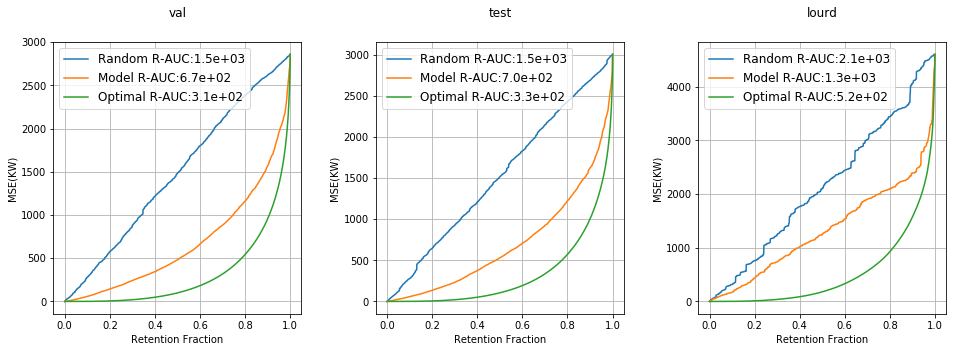

In [20]:
print(sqr_errors.keys())
sets_names = ['val', 'test','lourd']
error_retention_plot_allsets(uncertainties, sqr_errors, sets_names)

### F1 retention curves

#### Define threshold of acceptable errors

In [52]:
# Use an acceptable error threshold of (500 kW)^2
thresh =  10** 2 # moitié de rmse dans le tableau plus bas, au carré

#### Plot F1 retentions

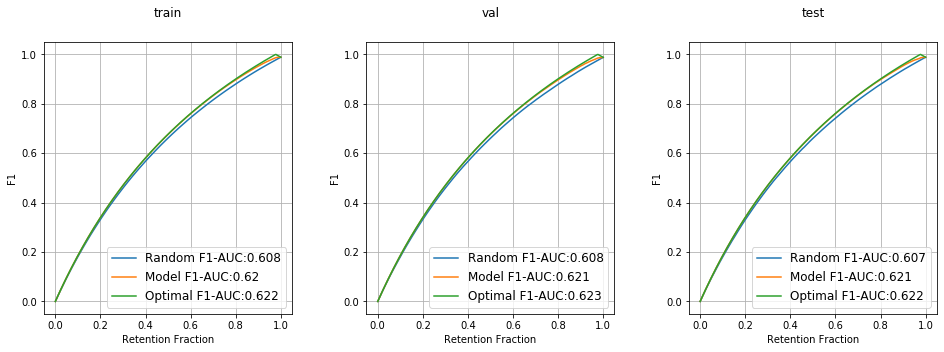

In [53]:
f1_retention_plot_allsets (uncertainties, sqr_errors, sets_names, thresh=20000)

## Predictive performance Tables

In [54]:
table_errors(predictions, datasets, target)

Classic metrics
╒════════╤══════════════════╤═════════════════╤══════════════╕
│ Data   │   RMSE Ens. (KW) │   MAE Ens. (KW) │     MAPE (%) │
╞════════╪══════════════════╪═════════════════╪══════════════╡
│ train  │               54 │              37 │  7.52009e+14 │
├────────┼──────────────────┼─────────────────┼──────────────┤
│ test   │               55 │              37 │ 25.71        │
├────────┼──────────────────┼─────────────────┼──────────────┤
│ val    │               52 │              36 │ 22.68        │
╘════════╧══════════════════╧═════════════════╧══════════════╛


In [55]:
table_auc(sets_names, sqr_errors, uncertainties, thresh)

AUCs
╒════════╤═════════╤══════════╤═════════════╕
│ Data   │   R-AUC │   F1-AUC │   F1 @ 95 % │
╞════════╪═════════╪══════════╪═════════════╡
│ train  │ 704.956 │    0.336 │       0.359 │
├────────┼─────────┼──────────┼─────────────┤
│ val    │ 677.231 │    0.345 │       0.371 │
├────────┼─────────┼──────────┼─────────────┤
│ test   │ 699.536 │    0.335 │       0.356 │
╘════════╧═════════╧══════════╧═════════════╛


# Plot predictions

In [56]:
# quel est le vol le plus utilisé dans l'entrainement ?
datasets["train"].groupby("flight")["angular_x"].count().sort_values()

flight
98      638
14      645
187     655
171     655
183     656
       ... 
102    1429
237    1435
210    1439
126    1458
272    1851
Name: angular_x, Length: 159, dtype: int64

In [37]:
# retrouver les index des predictions + repasser à std au lieu de variance -> dans un df
pred_test = predictions["test"]["denorm"]
pred_test_moy = np.zeros([pred_test.shape[1], 2])
for i in range(pred_test.shape[1]):
    pred_test_moy[i,0] = np.mean(pred_test[:,i,0])
    pred_test_moy[i,1] = np.mean(np.sqrt(pred_test[:,i,1]))

pred_test_moy = pd.DataFrame(pred_test_moy, index=datasets["test"].index, columns=["mean", "std"]).sort_index()
pred_test_moy

,mean,std
index,,
112,343.421082,109.305946
113,347.575562,108.671036
114,394.813843,94.241737
115,338.041687,110.851601
116,338.895691,111.158203
...,...,...
229905,231.257416,102.442909
229906,231.483871,103.105812
229907,213.369095,104.900642


In [58]:
# pred_test_moy.to_csv("./baselines/predictions/pred.csv")

In [67]:
datasets["test"].flight.unique()

array([  1,   4,  60,  83, 110, 114, 134, 137, 167, 179, 184, 197, 206,
       225, 233, 243, 251, 253])

time
0.00      343.421082
0.21      347.575562
0.31      394.813843
0.50      338.041687
0.61      338.895691
             ...    
169.10    276.218567
169.20    282.265594
169.30    267.788971
169.50    292.029175
169.70    252.185501
Name: mean, Length: 1132, dtype: float64


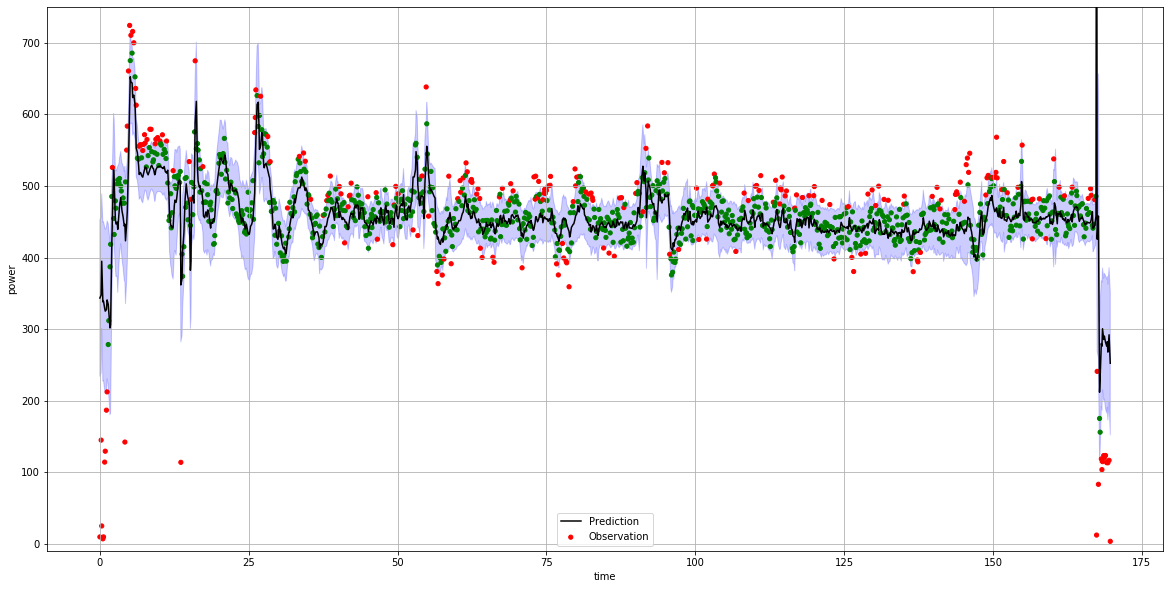

In [39]:
# plot comme puncc //pour les split ou les vols ne sont pas séparés 
def plot_flight_pred(datasets, flight, pred_test_moy, target):
    """ Plot one flight and its predictions given by the model, as well as real data for those points """
    figsize=(20,10)
    fig, ax = plt.subplots(figsize=figsize)
    # plot predictions with uncertainty
    ex_test = datasets.loc[datasets.flight == flight].sort_index()
    yerr = pred_test_moy.loc[ex_test.index, "std"].sort_index()
    moy = pred_test_moy.loc[ex_test.index,"mean"].sort_index()
    moy.index = ex_test.time
    print(moy)
    moy.plot(marker="", ax=ax, ls='-', label="Prediction", color="black")
    plt.fill_between(ex_test.time, moy.values - yerr, moy.values + yerr, color="blue", alpha=0.2)
    # plot real observations colored according to prediction valid or not 
    certain = abs(moy.values - ex_test[target].values) < yerr 
    certain = ["green" if x else "red" for x in certain]
    datasets.loc[ex_test.index,:].plot.scatter(x="time", y=target, marker=".", ax=ax, label="Observation", color=certain, s=70)

    # plt.xlim(250250, 250600)
    plt.legend()
    plt.grid()
    plt.ylim(-10, 750)
    plt.show()

plot_flight_pred(datasets["test"], 1, pred_test_moy, target)

In [ ]:
# plot comme puncc 
def plot_flight_pred(datasets, flight, pred_test_moy, test_name, target):
    """ Plot one flight and its predictions given by the model, as well as real data for those points """
    figsize=(20,10)
    fig, ax = plt.subplots(figsize=figsize)
    # plot line for data of this flight
    dataset_complete = pd.concat([datasets[k] for k in datasets.keys()])
    # plot predictions with uncertainty
    data_test = datasets[test_name]
    ex_test = data_test.loc[data_test.flight == flight].sort_index()
    yerr = pred_test_moy.loc[ex_test.index, "std"].sort_index()
    moy = pred_test_moy.loc[ex_test.index,"mean"].sort_index()
    moy.index = ex_test.time
    print(moy)
    moy.plot(marker="", ax=ax, ls='-', label="Prediction", color="black")
    plt.fill_between(ex_test.time, moy.values - yerr, moy.values + yerr, color="black", alpha=0.2)
    # plot real observations colored according to prediction valid or not 
    certain = abs(moy.values - ex_test[target].values) < yerr 
    certain = ["green" if x else "red" for x in certain]
    print(certain)
    dataset_complete.loc[ex_test.index,:].plot.scatter(x="time", y=target, marker=".", ax=ax, label="Observation", color=certain, s=70)

    # plt.xlim(250250, 250600)
    plt.legend()
    plt.grid()
    plt.show()

plot_flight_pred(datasets, 272, pred_test_moy, "test", target)